# ERC Risk Premia Portfolio Backtest

In this notebook we backtest a more advanced risk parity long-only portfolio of ETFs.

Review the basic riskpremia notebook in this directory first.

In [44]:
import os
import sys
import importlib
from itertools import repeat
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

In [45]:
# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a 'donotdelete.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola

In [46]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'], start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046684,50.798935,44.380001
2004-11-19,40.548504,50.393547,44.779999
2004-11-22,40.815384,50.656170,44.950001
2004-11-23,40.829636,50.719036,44.750000
2004-11-24,41.064480,50.719036,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [47]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()

cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [48]:
def calc_erc_weight(initial_weights, cov_mat, b):

    n = len(initial_weights)
    try:
        w = ffn.core._erc_weights_ccd(initial_weights, cov=cov_mat, b=b, maximum_iterations=1000, tolerance=1e-8)
    except ValueError:
        w = np.full(n, 1/n)
    
    return w

In [49]:
risk_budget = np.array([1,1,1])
initial_weights = np.array([1,1,1])

weight_df = ret_df[:-1].copy()

weight_df[:] = [calc_erc_weight(x, y, z) for x, y, z in zip(repeat(initial_weights), cov_mat, repeat(risk_budget))]

display(weight_df * 100)

/Users/richklee/repos/github.com/richklee/alphasim/venv/lib/python3.10/site-packages/ffn/core.py:1739: RuntimeWarning: invalid value encountered in sqrt
  sigma_x = np.sqrt(


Symbols,VTI,TLT,GLD
Date,,,
2004-11-19,33.333333,33.333333,33.333333
2004-11-22,33.333333,33.333333,33.333333
2004-11-23,33.333333,33.333333,33.333333
2004-11-24,33.333333,33.333333,33.333333
2004-11-26,18.431074,24.904798,56.664128
...,...,...,...
2022-09-30,27.687296,31.596091,40.716612
2022-10-03,26.732673,33.003300,40.264026
2022-10-04,26.885246,32.786885,40.327869


In [50]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df[2:], 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

/Users/richklee/repos/github.com/richklee/alphasim/alphasim/backtest.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices[CASH] = 1.0


price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-19 VTI       40.815384         0.000000      0.000000        0.000000   
           TLT       50.656170         0.000000      0.000000        0.000000   
           GLD       44.950001         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2004-11-22 VTI       40.829636        81.668553   3334.497250        0.334773   
...                        ...              ...           ...             ...   
2022-10-05 cash       1.000000       102.106766    102.106766        0.005047   
2022-10-06 VTI      182.399994        26.884254   4903.687726        0.246055   
           TLT      100.989998        62.996483   6362.014725        0.319230   
           GLD      157.880005        54.227442   8561.428790        0.429591   
           cash       1.000000       102.106766    102.106766        0.005123   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2004-11-19 VTI           0.333333      0.333333      True           0.333333   
           TLT           0.333333      0.333333      True           0.333333   
           GLD           0.333333      0.333333      True           0.333333   
           cash          0.000000     -1.000000     False           1.000000   
2004-11-22 VTI           0.333333     -0.001440     False           0.334773   
...                           ...           ...       ...                ...   
2022-10-05 cash          0.000000     -0.005047     False           0.005047   
2022-10-06 VTI           0.263158      0.017103     False           0.246055   
           TLT           0.332237      0.013007     False           0.319230   
           GLD           0.404605     -0.024986     False           0.429591   
           cash          0.000000     -0.005123     False           0.005123   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2004-11-19 VTI              0.333333  3333.333333   81.668553        10.0   
           TLT              0.333333  3333.333333   65.803106        10.0   
           GLD              0.333333  3333.333333   74.156469        10.0   
           cash             0.000000     0.000000    0.000000         0.0   
2004-11-22 VTI              0.000000     0.000000    0.000000         0.0   
...                              ...          ...         ...         ...   
2022-10-05 cash             0.000000     0.000000    0.000000         0.0   
2022-10-06 VTI              0.000000     0.000000    0.000000         0.0   
           TLT              0.000000     0.000000    0.000000         0.0   
           GLD              0.000000     0.000000    0.000000         0.0   
           cash             0.000000     0.000000    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2004-11-19 VTI          81.668553  
           TLT          65.803106  
           GLD          74.156469  
           cash        -30.000000  
2004-11-22 VTI          81.668553  
...                           ...  
2022-10-05 cash        102.106766  
2022-10-06 VTI          26.884254  
           TLT          62.996483  
           GLD          54.227442  
           cash        102.106766  

[18004 rows x 13 columns]

In [51]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df.tail(5))

941

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2022-03-07 GLD      191.509995        53.888750  10320.234259        0.421442   
2022-04-28 VTI      205.185242        36.371509   7462.896863        0.328775   
           GLD      176.910004        48.639813   8604.869520        0.379084   
2022-06-02 TLT      115.072121        54.638729   6287.394468        0.282589   
2022-09-12 VTI      196.933929        31.169808   6138.392808        0.295535   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2022-03-07 GLD           0.380392     -0.041050      True           0.380392   
2022-04-28 VTI           0.281755     -0.047020      True           0.281755   
           GLD           0.422633      0.043548      True           0.422633   
2022-06-02 TLT           0.325815      0.043226      True           0.325815   
2022-09-12 VTI           0.254902     -0.040633      True           0.254902   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2022-03-07 GLD             -0.041050 -1005.223912   -5.248937        10.0   
2022-04-28 VTI             -0.047020 -1067.312235   -5.201701        10.0   
           GLD              0.043548   988.507422    5.587629        10.0   
2022-06-02 TLT              0.043226   961.744472    8.357754        10.0   
2022-09-12 VTI             -0.040633  -843.971070   -4.285554        10.0   

                    end_portfolio  
datetime   Symbols                 
2022-03-07 GLD          48.639813  
2022-04-28 VTI          31.169808  
           GLD          54.227442  
2022-06-02 TLT          62.996483  
2022-09-12 VTI          26.884254

In [52]:
stats = calc_stats(result)
display(stats)

,equity
start,2004-11-19 00:00:00
end,2022-10-06 00:00:00
rf,0.0
total_return,0.992924
cagr,0.039326
max_drawdown,-0.225424
calmar,0.174453
mtd,-0.012514
three_month,-0.061446
six_month,-0.166622


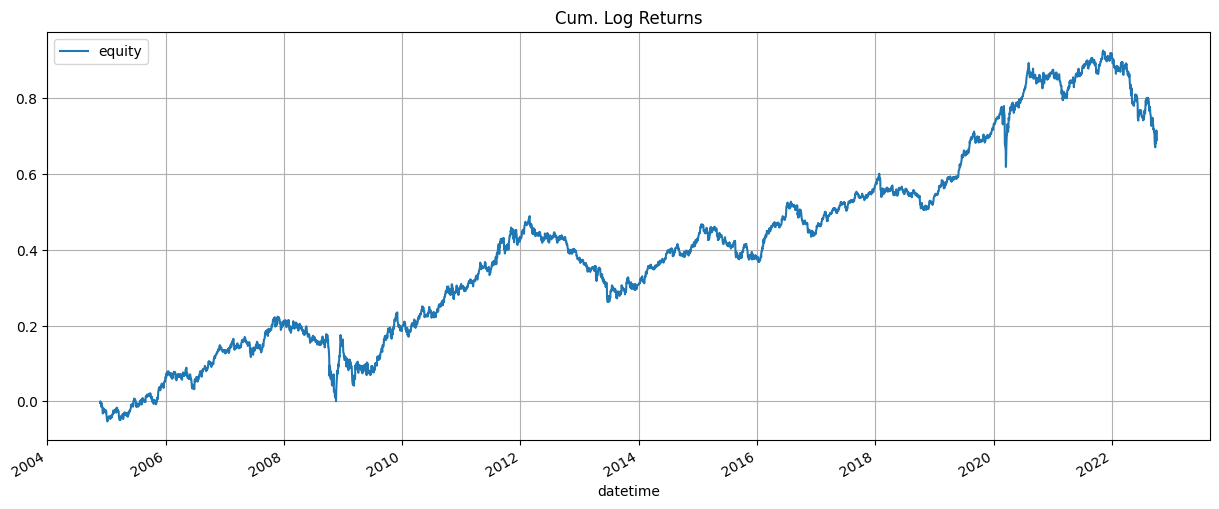

In [53]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

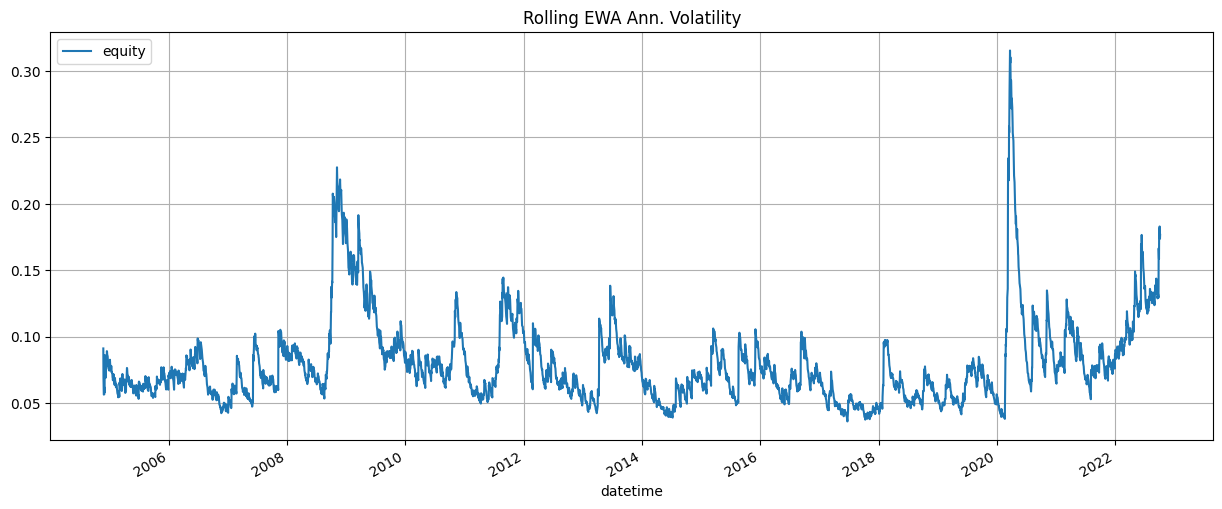

In [54]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()